# 神经网络

PyTorch 中，我们可以使用 torch.nn来构建神经网络。

前面已经讲过了 autograd，torch.nn 依赖 autograd 来定义模型并求导。nn.Module 中包含了构建神经网络所需的各个层和 forward(input) 方法，该方法返回神经网络的输出。

下面给出一个示例网络结构，该网络也是经典的  LeNet。

它是一个简单的前馈神经网络，它接受一个输入，然后一层接着一层地传递，最后输出计算的结果。


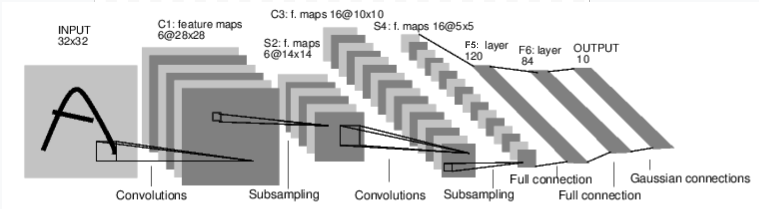

神经网络的典型训练过程如下：

1. 定义包含可学习参数（权重）的神经网络模型。
2. 在数据集上迭代。
3. 通过神经网络处理输入。
4. 计算损失（输出结果和正确值的差值大小）。
5. 将梯度反向传播回网络节点。
6. 更新网络的参数，一般可使用梯度下降等最优化方法。


In [3]:
import torch.nn as nn
import torch.nn.functional as F

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,6,3) # 输入1，输出6，卷积核3x3
        self.conv2 = nn.Conv2d(6,16,3) # 输入6，输出16，卷积核3x3
        self.fc1 = nn.Linear(16*6*6,120)  # 图像是6*6的
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,10)
    def forward(self,x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) # 池化核2*2
        x = F.max_pool2d(F.relu(self.conv2(x)),2) # 方矩阵可以只传一个参数
        x = x.view(-1,self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self,x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *=s
        return num_features
    
net = Net()
net

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

模型中必须要定义 forward 函数，backward 函数（用来计算梯度）会被 autograd 自动创建。可以在 forward 函数中使用任何针对 Tensor 的操作。

In [5]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


测试随机输入 
32
×
32
32×32。注意，网络（LeNet）期望的输入大小是 
32×32，如果使用 MNIST 数据集（
28×28）来训练这个网络，请把图片大小重新调整到 
32×32。

In [6]:
import torch
input = torch.randn(1, 1, 32, 32)
out = net(input)
out

tensor([[-0.0737, -0.0060,  0.0169,  0.0839,  0.0640, -0.0752, -0.0491, -0.1698,
          0.0864, -0.0406]], grad_fn=<AddmmBackward0>)

In [7]:
net.zero_grad()
out.backward(torch.randn(1, 10))

torch.nn 只支持小批量输入。整个 torch.nn 包都只支持小批量样本，而不支持单个样本。例如，nn.Conv2d 接受一个 4 维的张量，每一维分别是 sSamples x nChannels x Height x Width（样本数 x 通道数 x 高 x 宽）。如果是单个样本，需使用 input.unsqueeze(0) 来添加其它的维数解决问题。

在继续之前，我们回顾一下到目前为止用到的类。

- torch.Tensor：自动调用 backward() 实现支持自动梯度计算的多维数组，并且保存关于这个向量的梯度。
- nn.Module：神经网络模块。封装参数、移动到 GPU 上运行、导出、加载等。
- nn.Parameter：变量，当把它赋值给一个 Module 时，被自动地注册为一个参数。
- autograd.Function：实现自动求导操作的前向和反向定义，每个变量操作至少创建一个函数节点。

至此，我们以及完成：
- 定义一个网络
- 处理输入，调用 backword。   

接下来还需要：

- 计算损失。
- 更新网络权重。

# 损失函数

一个损失函数接受一对 (output, target) 作为输入，计算一个值来估计网络的输出和目标值相差多少。

torch.nn 中有很多不同的  损失函数。nn.MSELoss 是一个比较简单的损失函数，它可以用来计算输出和目标间的  均方误差，例如：

In [8]:
output = net(input)
target = torch.randn(10)  # 随机值作为样例
target = target.view(1, -1)  # 使 target 和 output 的 shape 相同
criterion = nn.MSELoss()

loss = criterion(output, target)
loss
"""
input → conv2d → relu → maxpool2d → conv2d → relu → maxpool2d
      → view → linear → relu → linear → relu → linear
      → MSELoss
      → loss
"""

'\ninput → conv2d → relu → maxpool2d → conv2d → relu → maxpool2d\n      → view → linear → relu → linear → relu → linear\n      → MSELoss\n      → loss\n'

所以，当我们调用 loss.backward() 时，会针对整个图执行微分操作。图中所有具有 requires_grad=True 的张量的 .grad 梯度会被累积起来。为了说明该情况，我们回溯几个步骤：

In [9]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

调用 loss.backward() 获得反向传播的误差。但是在调用前需要清除已存在的梯度，否则梯度将被累加到已存在的梯度。现在，我们将调用 loss.backward()，并查看 conv1 层的偏差（bias）项在反向传播前后的梯度。下方的代码只能执行一次。

In [10]:
net.zero_grad()  
print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)
loss.backward()
print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0043,  0.0064, -0.0069,  0.0002,  0.0036, -0.0188])


更新权重


In [11]:
lr = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data*lr)

In [12]:
import torch.optim as optim

# 创建优化器
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 执行一次训练迭代过程
optimizer.zero_grad()  # 梯度置零
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()  # 更新
loss

tensor(1.1816, grad_fn=<MseLossBackward0>)

# 训练一个分类器


上面，你已经看到如何去定义一个神经网络，计算损失值和更新网络的权重。接下来，我们实现一个图像分类神经网络。

一般情况下处理图像、文本、音频和视频数据时，可以使用标准的 Python 来加载数据为 NumPy 数组。然后把这个数组转换成torch.*Tensor。
- 图像可以使用 Pillow, OpenCV。
- 音频可以使用 SciPy, librosa。
- 文本可以使用原始 Python 和 Cython 来加载，或者使用 NLTK 或 SpaCy 处理。

特别地，对于图像任务，PyTorch 提供了专门的包 torchvision，它包含了处理一些基本图像数据集的方法。这些数据集包括 Imagenet, CIFAR10, MNIST 等。除了数据加载以外，torchvision 还包含了图像转换器，torchvision.datasets 和 torch.utils.data.DataLoader 数据加载器。

torchvision不仅提供了巨大的便利，也避免了代码的重复。接下来，我们使用 CIFAR10 数据集完成分类器训练。该数据集有如下 10 个类别：airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck。CIFAR-10 的图像都是$ 3×32×32$ ，即 3 个颜色通道，$32×32$ 像素。



训练一个图像分类器，基本流程如下：

- 使用 torchvision 加载和归一化 CIFAR10 训练集和测试集。
- 定义一个卷积神经网络。
- 定义损失函数。
- 在训练集上训练网络。
- 在测试集上测试网络。

使用 torchvision 可以非常容易地加载 CIFAR10。torchvision 的输出是 [0,1] 的 PILImage 图像，我们把它转换为归一化范围为 [-1, 1] 的张量。

In [3]:
import torch.utils
import torchvision
import torchvision.transforms as transforms

# 图像预处理步骤
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))]
)



这段代码使用了 `torchvision.transforms` 模块中的 `Compose` 函数，定义了一个图像预处理的流程。具体来说，它包含两个步骤：

1. **`transforms.ToTensor()`**:
   - 将图像（通常是 PIL 图像或 NumPy 数组）转换为 PyTorch 张量（`torch.Tensor`）。
   - 同时，它会将图像的像素值从范围 `[0, 255]` 缩放到 `[0.0, 1.0]`。

2. **`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`**:
   - 对图像进行标准化处理。
   - 第一个元组 `(0.5, 0.5, 0.5)` 是均值（mean），第二个元组 `(0.5, 0.5, 0.5)` 是标准差（std）。
   - 对于每个通道（RGB），它会执行以下操作：
   $$\text{normalized\_channel} = \frac{\text{channel} - \text{mean}}{\text{std}}$$
   - 由于输入图像的像素值范围是 `[0.0, 1.0]`，经过标准化后，像素值范围会变为 `[-1.0, 1.0]`。

三个是因为RGB图像

In [ ]:
# 训练数据加载器
trainset = torchvision.datasets.CIFAR10(
    root = 'D:\CODE\datasets',train = True,download=True,transform=transform
)
trainloader = torch.utils.data.DataLoader(
    trainset,batch_size = 4,shuffle = True,num_workers = 2
)


# 测试数据加载器

testset = torchvision.datasets.CIFAR10(
    root = 'D:\CODE\datasets',train = False,transform=transform,download=True
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

 12%|█▏        | 20512768/170498071 [03:10<25:47, 96943.59it/s]  

In [ ]:
trainloader, testloader


(<torch.utils.data.dataloader.DataLoader at 0x16d6e27f0d0>,
 <torch.utils.data.dataloader.DataLoader at 0x16d731b6490>)

  cat  frog  frog  bird


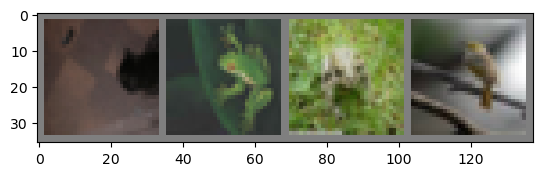

In [ ]:
# 可视化其中的一些训练图像。
import matplotlib as plt
%matplotlib inline
import numpy as np
def imshow(img):
    img = img/2+0.5
    npimg = img.numpy()
    plt.pyplot.imshow(np.transpose(npimg, (1, 2, 0)))

# 获取随机数据
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 展示图像
imshow(torchvision.utils.make_grid(images))
# 显示图像标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))